In [129]:
from comet import COMET
# import datautils
from tasks.classification import eval_classification
from preprocessing.tdbrain_preprocessing import load_tdbrain

import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import copy
from sklearn.utils import shuffle
from utils import plot_channels
from utils import process_batch_trial
from utils import split_data_label
from utils import start_logging
from utils import stop_logging

from datetime import datetime

In [130]:
RANDOM_SEED = 45

def seed_everything(seed=42):
    """
    Seed everything.
    """   
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # training is extremely slow when do following setting
    # torch.backends.cudnn.benchmark = False
    # torch.backends.cudnn.deterministic = True

# Autoload the modified python file
%reload_ext autoreload
%autoreload 2

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [131]:
working_directory = 'test_run/TDBRAIN/Supervised/'
dataset_save_path = working_directory
if not os.path.exists(working_directory):
    os.mkdir(working_directory)

logging_directory = 'logging/TDBRAIN/Supervised/'
if not os.path.exists(logging_directory):
    os.mkdir(logging_directory)

In [132]:
test = np.load("../datasets/TDBRAIN/Label/label.npy")
print(test[np.where(test[:,0]==0)][:,1])  # healthy
print(test[np.where(test[:,0]==1)][:,1])  # positive

In [133]:
data_path = "../datasets/TDBRAIN/Feature/"
label_path = "../datasets/TDBRAIN/Label/label.npy"
train_ids = list(range(1,18)) + list(range(29,46))
val_ids = [18, 19, 20, 21] + [46, 47, 48, 49]  # 8 subjects, 4 positive 4 healthy
test_ids = [22, 23, 24, 25] + [50, 51, 52, 53]  # 8 subjects, 4 positive 4 healthy"""
trial_train_data, trial_val_data, trial_test_data, trial_train_labels, trial_val_labels, trial_test_labels = load_tdbrain(train_ids, val_ids, test_ids, data_path, label_path)
print(trial_train_data.shape)
print(trial_train_labels.shape)
print(trial_val_data.shape)
print(trial_val_labels.shape)
print(trial_test_data.shape)
print(trial_test_labels.shape)

In [134]:
# normalize data
trial_train_data = process_batch_trial(trial_train_data, bandpass_filter=False)
trial_val_data = process_batch_trial(trial_val_data, bandpass_filter=False)
trial_test_data = process_batch_trial(trial_test_data, bandpass_filter=False)
print(trial_train_data.shape)
print(trial_val_data.shape)
print(trial_test_data.shape)

In [135]:
# Split data and labels
sample_train_data, sample_train_labels = split_data_label(trial_train_data,trial_train_labels, sub_length=256, overlapping=0.5)
sample_val_data, sample_val_labels = split_data_label(trial_val_data,trial_val_labels, sub_length=256, overlapping=0.5)
sample_test_data, sample_test_labels = split_data_label(trial_test_data,trial_test_labels, sub_length=256, overlapping=0.5)
print(sample_train_data.shape)
print(sample_val_data.shape)
print(sample_test_data.shape)
print(sample_train_labels.shape)
print(sample_val_labels.shape)
print(sample_test_labels.shape)

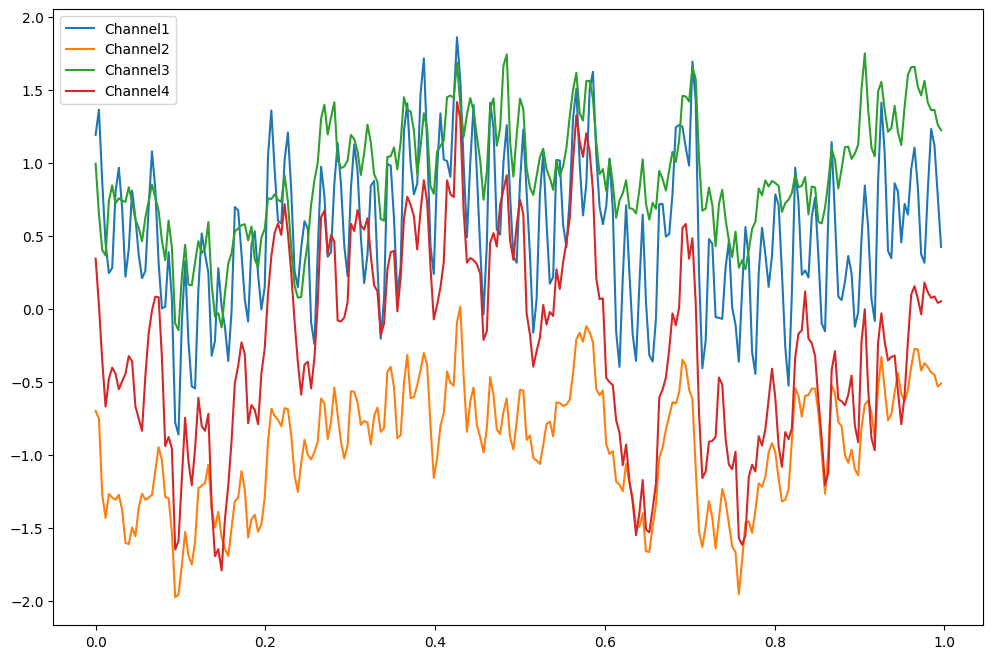

In [136]:
# plot first sample, first four channels
plot_channels(1, sample_train_data[0][:,:4])

## Depth = 12, output_dims = 320

### Callback functions

In [137]:
def pretrain_callback(model, loss):
    n = model.pretrain_n_epochs
    metrics_dict = {}
    if n % 1 == 0:
        metrics_dict = eval_classification(model, sample_train_data, sample_train_labels[:, 0], sample_val_data, sample_val_labels[:, 0], fraction=1)
        print(metrics_dict)
        # f1 = metrics_dict['F1']
        # if loss < model.min_loss:
        # if f1 > model.linear_f1:
    # if n == 100: # save the last epoch
        # model.min_loss = loss
        # model.linear_f1 = f1
        model.save(f"{working_directory}seed{RANDOM_SEED}_pretrain_model.pt")
    return metrics_dict['F1']

In [138]:
def fine_tine_callback(model, f1, fraction=None):
    n = model.finetune_n_epochs
    if n % 1 == 0:
        # if loss < model.min_loss:
        if f1 > model.finetune_f1:
            # model.min_loss = loss
            model.finetune_f1 = f1
            if fraction:
                model.finetune_save(f"{working_directory}seed{RANDOM_SEED}_max_f1_{fraction}_encoder_model.pt",f"{working_directory}seed{RANDOM_SEED}_max_f1_{fraction}_proj_head_model.pt")
            else:
                fraction = 1.0
                model.finetune_save(f"{working_directory}seed{RANDOM_SEED}_max_f1_{fraction}_encoder_model.pt",f"{working_directory}seed{RANDOM_SEED}_max_f1_{fraction}_proj_head_model.pt")
    return fine_tine_callback

In [139]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"The program will run on {device}!")

#### Random init

In [140]:
seed_everything(RANDOM_SEED)
model = COMET(
    input_dims=33,
    device=0,
    lr=0.0005,
    depth=12,
    sample_batch_size=128,
    output_dims=320,
    after_epoch_callback=fine_tine_callback,
)

model.finetune_f1 = -float('inf')

start_logging(RANDOM_SEED, logging_directory)
print("Random init for validation set")
model.finetune_predict(sample_val_data, sample_val_labels[:,0], mask=None, encoding_window='full_series')
print("Random init for test set")
model.finetune_predict(sample_test_data, sample_test_labels[:,0], mask=None, encoding_window='full_series')
print()
stop_logging()

model.save(f"{working_directory}seed{RANDOM_SEED}_pretrain_model.pt")

#### Logistic regression

In [141]:
seed_everything(RANDOM_SEED)
start_logging(RANDOM_SEED, logging_directory)
fraction = 1.0
val_metrics_dict = eval_classification(model, sample_train_data, sample_train_labels[:, 0], sample_val_data, sample_val_labels[:, 0], fraction=fraction)
print(f"Linear evaluation for {fraction} fraction of validation set\n",val_metrics_dict)
test_metrics_dict = eval_classification(model, sample_train_data, sample_train_labels[:, 0], sample_test_data, sample_test_labels[:, 0], fraction=fraction)
print(f"Linear evaluation for {fraction} fraction of test set\n",test_metrics_dict)
print()
stop_logging()

In [142]:
seed_everything(RANDOM_SEED)
start_logging(RANDOM_SEED, logging_directory)
fraction = 0.3
val_metrics_dict = eval_classification(model, sample_train_data, sample_train_labels[:, 0], sample_val_data, sample_val_labels[:, 0], fraction=fraction)
print(f"Linear evaluation for {fraction} fraction of validation set\n",val_metrics_dict)
test_metrics_dict = eval_classification(model, sample_train_data, sample_train_labels[:, 0], sample_test_data, sample_test_labels[:, 0], fraction=fraction)
print(f"Linear evaluation for {fraction} fraction of test set\n",test_metrics_dict)
print()
stop_logging()

In [143]:
seed_everything(RANDOM_SEED)
start_logging(RANDOM_SEED, logging_directory)
fraction = 0.1
val_metrics_dict = eval_classification(model, sample_train_data, sample_train_labels[:, 0], sample_val_data, sample_val_labels[:, 0], fraction=fraction)
print(f"Linear evaluation for {fraction} fraction of validation set\n",val_metrics_dict)
test_metrics_dict = eval_classification(model, sample_train_data, sample_train_labels[:, 0], sample_test_data, sample_test_labels[:, 0], fraction=fraction)
print(f"Linear evaluation for {fraction} fraction of test set\n",test_metrics_dict)
print()
stop_logging()

In [144]:
seed_everything(RANDOM_SEED)
start_logging(RANDOM_SEED, logging_directory)
fraction = 0.01
val_metrics_dict = eval_classification(model, sample_train_data, sample_train_labels[:, 0], sample_val_data, sample_val_labels[:, 0], fraction=fraction)
print(f"Linear evaluation for {fraction} fraction of validation set\n",val_metrics_dict)
test_metrics_dict = eval_classification(model, sample_train_data, sample_train_labels[:, 0], sample_test_data, sample_test_labels[:, 0], fraction=fraction)
print(f"Linear evaluation for {fraction} fraction of test set\n",test_metrics_dict)
print()
stop_logging()

#### Supervised leaning (No pretrain)

#### fraction = 1.0

In [145]:
seed_everything(RANDOM_SEED)
model = COMET(
    input_dims=33,
    device=0,
    lr=0.0001,
    depth=12,
    sample_batch_size=128,
    output_dims=320,
    after_epoch_callback=fine_tine_callback,
)

model.finetune_f1 = -float('inf')

In [146]:
seed_everything(RANDOM_SEED)
fraction = 1.0
epoch_loss_list, epoch_f1_list = model.finetune_fit(sample_train_data, sample_train_labels[:, 0], sample_val_data, sample_val_labels[:, 0], encoding_window='full_series',finetune_epochs=100, finetune_lr=0.0001, fraction=fraction)

In [147]:
seed_everything(RANDOM_SEED)
model = COMET(
    input_dims=33,
    device=0,
    lr=0.0001,
    depth=12,
    sample_batch_size=128,
    output_dims=320,
    after_epoch_callback=fine_tine_callback,
)

model.finetune_f1 = -float('inf')

model.finetune_load(f"{working_directory}seed{RANDOM_SEED}_max_f1_{fraction}_encoder_model.pt",f"{working_directory}seed{RANDOM_SEED}_max_f1_{fraction}_proj_head_model.pt")

start_logging(RANDOM_SEED, logging_directory)
print(f"Supervised for {fraction} fraction of validation set")
model.finetune_predict(sample_val_data, sample_val_labels[:,0], mask=None, encoding_window='full_series')
print(f"Supervised for {fraction} fraction of test set")
model.finetune_predict(sample_test_data, sample_test_labels[:,0], mask=None, encoding_window='full_series')
print()
stop_logging()

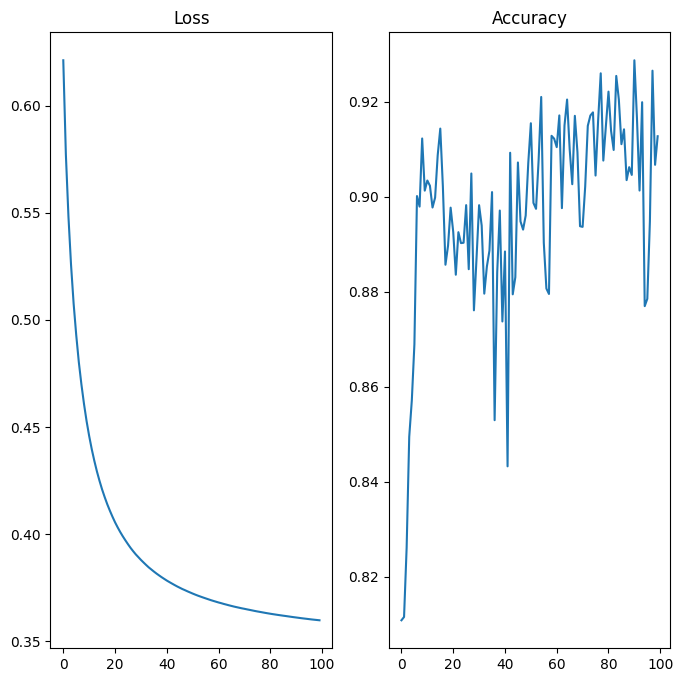

In [148]:
plt.figure(1, figsize=(8, 8))
plt.subplot(121)
plt.plot(epoch_loss_list)
plt.title('Loss')
plt.subplot(122)
plt.plot(epoch_f1_list)
plt.title('Accuracy')
plt.show()

#### Fraction = 0.3

In [149]:
seed_everything(RANDOM_SEED)
model = COMET(
    input_dims=33,
    device=0,
    lr=0.0001,
    depth=12,
    sample_batch_size=128,
    output_dims=320,
    after_epoch_callback=fine_tine_callback,
)

model.finetune_f1 = -float('inf')

In [150]:
seed_everything(RANDOM_SEED)
fraction = 0.3
epoch_loss_list, epoch_f1_list = model.finetune_fit(sample_train_data, sample_train_labels[:, 0], sample_val_data, sample_val_labels[:, 0], encoding_window='full_series',finetune_epochs=100, finetune_lr=0.0001, fraction=fraction)

In [151]:
seed_everything(RANDOM_SEED)
model = COMET(
    input_dims=33,
    device=0,
    lr=0.0001,
    depth=12,
    sample_batch_size=128,
    output_dims=320,
    after_epoch_callback=fine_tine_callback,
)

model.finetune_f1 = -float('inf')

model.finetune_load(f"{working_directory}seed{RANDOM_SEED}_max_f1_{fraction}_encoder_model.pt",f"{working_directory}seed{RANDOM_SEED}_max_f1_{fraction}_proj_head_model.pt")

start_logging(RANDOM_SEED, logging_directory)
print(f"Supervised for {fraction} fraction of validation set")
model.finetune_predict(sample_val_data, sample_val_labels[:,0], mask=None, encoding_window='full_series')
print(f"Supervised for {fraction} fraction of test set")
model.finetune_predict(sample_test_data, sample_test_labels[:,0], mask=None, encoding_window='full_series')
print()
stop_logging()

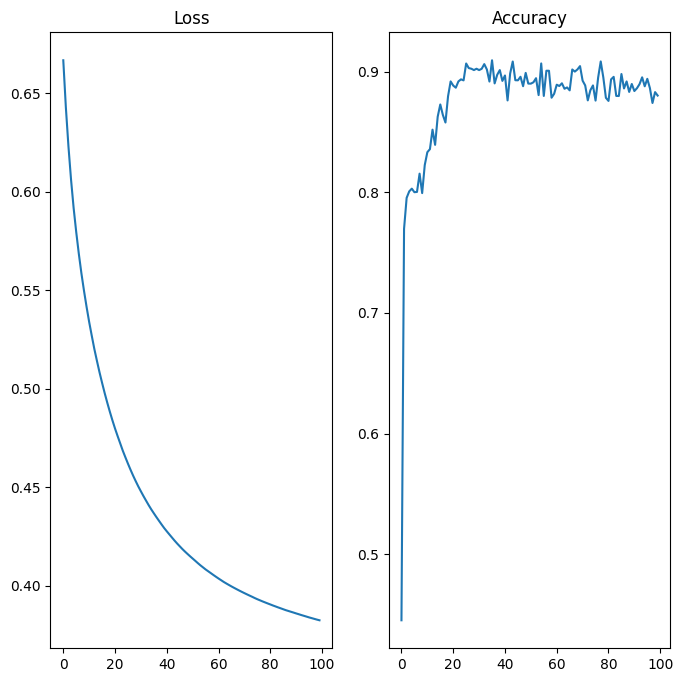

In [152]:
plt.figure(1, figsize=(8, 8))
plt.subplot(121)
plt.plot(epoch_loss_list)
plt.title('Loss')
plt.subplot(122)
plt.plot(epoch_f1_list)
plt.title('Accuracy')
plt.show()

#### Fraction = 0.1

In [153]:
seed_everything(RANDOM_SEED)
model = COMET(
    input_dims=33,
    device=0,
    lr=0.0001,
    depth=12,
    sample_batch_size=128,
    output_dims=320,
    after_epoch_callback=fine_tine_callback,
)

model.finetune_f1 = -float('inf')

In [154]:
seed_everything(RANDOM_SEED)
fraction = 0.1
epoch_loss_list, epoch_f1_list = model.finetune_fit(sample_train_data, sample_train_labels[:, 0], sample_val_data, sample_val_labels[:, 0], encoding_window='full_series',finetune_epochs=100, finetune_lr=0.0001, fraction=fraction)

In [155]:
seed_everything(RANDOM_SEED)
model = COMET(
    input_dims=33,
    device=0,
    lr=0.0001,
    depth=12,
    sample_batch_size=128,
    output_dims=320,
    after_epoch_callback=fine_tine_callback,
)

model.finetune_f1 = -float('inf')

model.finetune_load(f"{working_directory}seed{RANDOM_SEED}_max_f1_{fraction}_encoder_model.pt",f"{working_directory}seed{RANDOM_SEED}_max_f1_{fraction}_proj_head_model.pt")

start_logging(RANDOM_SEED, logging_directory)
print(f"Supervised for {fraction} fraction of validation set")
model.finetune_predict(sample_val_data, sample_val_labels[:,0], mask=None, encoding_window='full_series')
print(f"Supervised for {fraction} fraction of test set")
model.finetune_predict(sample_test_data, sample_test_labels[:,0], mask=None, encoding_window='full_series')
print()
stop_logging()

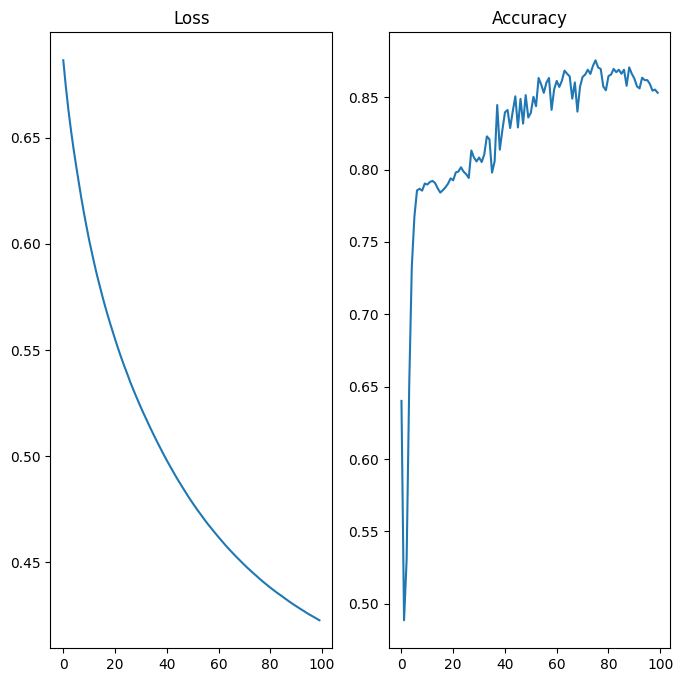

In [156]:
plt.figure(1, figsize=(8, 8))
plt.subplot(121)
plt.plot(epoch_loss_list)
plt.title('Loss')
plt.subplot(122)
plt.plot(epoch_f1_list)
plt.title('Accuracy')
plt.show()

#### Fraction = 0.01

In [157]:
seed_everything(RANDOM_SEED)
model = COMET(
    input_dims=33,
    device=0,
    lr=0.0001,
    depth=12,
    sample_batch_size=128,
    output_dims=320,
    after_epoch_callback=fine_tine_callback,
)

model.finetune_f1 = -float('inf')

In [158]:
seed_everything(RANDOM_SEED)
fraction = 0.01
epoch_loss_list, epoch_f1_list = model.finetune_fit(sample_train_data, sample_train_labels[:, 0], sample_val_data, sample_val_labels[:, 0], encoding_window='full_series',finetune_epochs=100, finetune_lr=0.0001, fraction=fraction)

In [159]:
seed_everything(RANDOM_SEED)
model = COMET(
    input_dims=33,
    device=0,
    lr=0.0001,
    depth=12,
    sample_batch_size=128,
    output_dims=320,
    after_epoch_callback=fine_tine_callback,
)

model.finetune_f1 = -float('inf')

model.finetune_load(f"{working_directory}seed{RANDOM_SEED}_max_f1_{fraction}_encoder_model.pt",f"{working_directory}seed{RANDOM_SEED}_max_f1_{fraction}_proj_head_model.pt")

start_logging(RANDOM_SEED, logging_directory)
print(f"Supervised for {fraction} fraction of validation set")
model.finetune_predict(sample_val_data, sample_val_labels[:,0], mask=None, encoding_window='full_series')
print(f"Supervised for {fraction} fraction of test set")
model.finetune_predict(sample_test_data, sample_test_labels[:,0], mask=None, encoding_window='full_series')
print()
stop_logging()

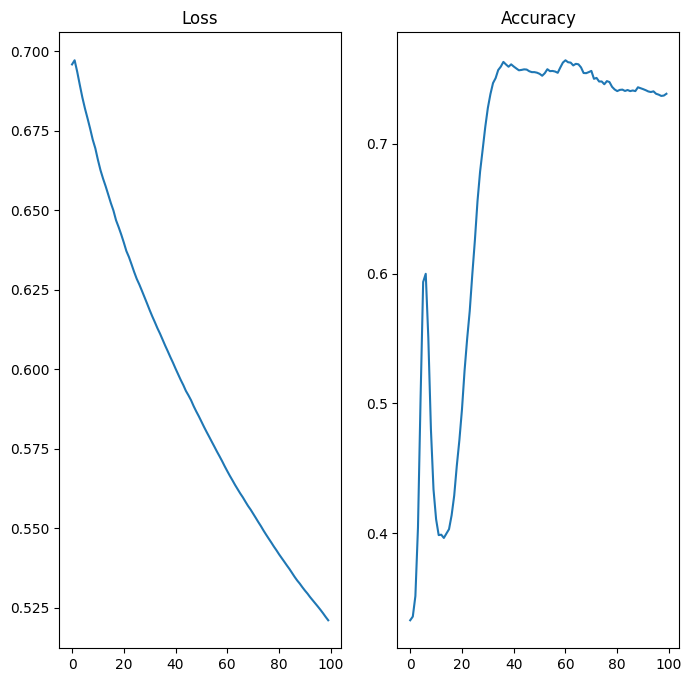

In [160]:
plt.figure(1, figsize=(8, 8))
plt.subplot(121)
plt.plot(epoch_loss_list)
plt.title('Loss')
plt.subplot(122)
plt.plot(epoch_f1_list)
plt.title('Accuracy')
plt.show()